In [1]:
import aplpy
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.convolution import convolve_fft, Gaussian2DKernel
import math 
from astropy import units as u
from scipy.interpolate import UnivariateSpline
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import sys
from numpy.random import rand,seed
from pylab import *

In [2]:
sys.path.insert(1, '/Users/hannahkoziol/Dropbox/Research/python_modules/plfit')
import plfit

In [21]:
#LOADING IN DATA
mosiac = fits.open('/Users/hannahkoziol/Dropbox/Research/CMZoom_continuum_pbcor_feathered.fits')
mask = fits.open('/Users/hannahkoziol/Dropbox/Research/CMZoom_Mask_new.fits')
mosiac_data = mosiac[0].data
mask_data = mask[0].data
mosiac_flat = mosiac_data.flatten()
mask_flat = mask_data.flatten()

In [9]:
region_names = np.array(['G1.683-0.089',
                      'G1.670-0.130',
                      'G1.651-0.050',
                      'G1.602+0.018',
                      'G1.085-0.027',
                      'G1.038-0.074',
                      'G0.891-0.048',
                      'G0.714-0.100',
                      'G0.699-0.028',
                      'G0.619+0.012',
                      'G0.489+0.010',
                      'G0.412+0.052',
                      'G0.393-0.034',
                      'G0.380+0.050',
                      'G0.340+0.055',
                      'G0.326-0.085',
                      'G0.316-0.201',
                      'G0.253+0.016',
                      'G0.212-0.001',
                      'G0.145-0.086',
                      'G0.106-0.082',
                      'G0.070-0.035',
                      'G0.068-0.075',
                      'G0.054+0.027',
                      'G0.014+0.021',
                      'G0.001-0.058',
                      'G359.948-0.052',
                      'G359.889-0.093',
                      'G359.865+0.022',
                      'G359.863-0.069',
                      'G359.734+0.002',
                      'G359.648-0.133',
                      'G359.611+0.018',
                      'G359.615-0.243',
                      'G359.484-0.132',
                      'G359.137+0.031'])

In [10]:
cnames = np.array(['',
                 '',
                 '',
                 'The Dancer Cloud',
                 '',
                 '',
                 '',
                 'The Chela Cloud',
                 'Sgr B2',
                 'Sgr B2 SE',
                 'Dust Ridge Clouds E\\&F',
                 'Dust Ridge Cloud D',
                 '',
                 'Dust Ridge Cloud C',
                 'Dust Ridge Cloud B',
                 '',
                 '',
                 'The Brick',
                 '',
                 'The Straw Cloud',
                 'The Sticks Cloud',
                 '',
                 'The Stone Cloud',
                 '',
                 '',
                 'The 20 km/s cloud',
                 'Sgr A* region',
                 'The 50 km/s cloud',
                 '',
                 '',
                 '',
                 '',
                 '',
                 'Sgr C',
                 '',
                 ''])

In [14]:
distance        = 8178. # distance to GC; (GRAVITY collaboration 2019)
Wave            = (3.0e8/226.0e9) # define the wavelength from the SMA dust continuum frequency. 
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d # this kappa is the dust opacity, it's kind of complicated where it comes from, but if you're interested I can find you some stuff about it!
mu              = 2.8 # This mu is the mean atomic weight. 
hplanck = 6.626176e-34 #Joule seconds
clight = 3e8 #m/s
kboltzmann = 1.380649e-23 #Joule/Kelvin
mh = 1.6737236e-27

In [12]:
def planck_wave(Wave, Temp):
    planck_conv_wave = 1.e-26 *clight /Wave**2.0
    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave
    return planck

In [13]:
def column_density(Wave, Temp, Kappa, Flux_Density, mu):
    B = planck_wave(Wave, Temp)
    N = Flux_Density / (mu * (mh*1.e3) * Kappa * B)
    return N

In [46]:
#RETRIEVING CLOUD
def find_cloud(mask_number):
    cloud_mask = np.argwhere(mask_flat == mask_number)
    cloud_data = mosiac_flat[cloud_mask]
    column_density_cloud_array = column_density(Wave, 25, Kappa, cloud_data, mu)
    return flat_column_density_cloud

In [48]:
#CLOUD NAME
def cloud_name(mask_number):
    cloud_name = []
    if cnames[(mask_number - 1)] != '':
        cloud_name = cnames[(mask_number - 1)]
    else:
        cloud_name = region_names[(mask_number - 1)]
    return cloud_name

In [51]:
#CREATING HISTOGRAMS AND SPLINE INPUTS
def histogram_before_fit(column_density):
    fig, ax = plt.subplots()
    plt.hist(column_density, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "CMZoom Cloud", color='mediumpurple', alpha=0.99)
    cloud_hist = plt.hist(column_density, bins=np.logspace(22, 23.5, 30), log=True, color='mediumpurple', alpha=0.3)
    ax.set_xscale('log')
    plt.xlabel('$Log_{10}$ Column Density $\#/cm^2$')
    plt.ylabel('$Log_{10} Frequency$')
    plt.legend(loc = 'lower left')
    plt.close()
    
    cloud_x = cloud_hist[1]
    cloud_mid = [(a + b) /2 for a,b in zip(cloud_x[:-1], cloud_x[1:])]
    cloud_y = cloud_hist[0]
    x_cloud_x = np.array(cloud_mid)
    y_cloud_y = np.array(cloud_y)
    
    return x_cloud_x, y_cloud_y

In [49]:
#COMBINING THESE FUNCTIONS
def histogram_harvesting(cloud_mask_number):
    cloud_data_flat_array = find_cloud(cloud_mask_number)
    return histogram_before_fit(cloud_data_flat_array)

In [5]:
#SPLINE FITTING ROUTINE
def spline_method(x_data, y_data):
    spl = UnivariateSpline(x_data, np.log(y_data), k = 1, s = .03)
    x_num_array = np.linspace(min(x_data), max(x_data), 500)
    deriv = spl.derivative(1)

    plt.plot(x_data, y_data, label = 'Data' )
    plt.plot(x_num_array, np.exp(spl(x_num_array)), label = 'Fit', linestyle = ':', color = 'red')
    plt.legend()
    plt.show()
    
    plt.plot(x_num_array, deriv(x_num_array), label = '1st Derivative')
    plt.xscale('log')
    plt.legend()
    plt.show()
    
    max_deriv = deriv(x_num_array)[1]
    x_min_value = x_num_array[np.argwhere(deriv(x_num_array) < max_deriv)][0]
    
    
    return x_min_value

In [6]:
#ADDING FIT LINE
def plotpdf(self,x=None,xmin=None,alpha=None,nbins=30,dolog=True,dnds=False,
            drawstyle='steps-post', histcolor='k', plcolor='r', **kwargs):
        """
        Plots PDF and powerlaw.

        kwargs is passed to pylab.hist and pylab.plot
        """
        if not(x): x=self.data
        if not(xmin): xmin=self._xmin
        if not(alpha): alpha=self._alpha

        x=np.sort(x)
        n=len(x)

        plt.gca().set_xscale('log')
        plt.gca().set_yscale('log')

        if dnds:
            hb = plt.hist(x,bins=np.logspace(log10(min(x)),log10(max(x)),nbins, histtype = 'step'))
            h = hb[0]
            b = hb[1]
            db = hb[1][1:]-hb[1][:-1]
            h = h/db
            plt.plot(b[:-1],h,drawstyle=drawstyle,color=histcolor,**kwargs)
            #alpha -= 1
        elif dolog:
            hb = plt.hist(x,bins=np.logspace(log10(min(x)),log10(max(x)),nbins),log=True,fill=False,edgecolor='none', histtype = 'step', **kwargs)
            alpha -= 1
            h,b=hb[0],hb[1]
        else:
            hb = plt.hist(x,bins=np.linspace((min(x)),(max(x)),nbins),fill=False,edgecolor='none', histtype = 'none', **kwargs)
            h,b=hb[0],hb[1]
        # plotting points are at the center of each bin
        b = (b[1:]+b[:-1])/2.0

        q = x[x>=xmin]
        px = (alpha-1)/xmin * (q/xmin)**(-alpha)

        # Normalize by the median ratio between the histogram and the power-law
        # The normalization is semi-arbitrary; an average is probably just as valid
        plotloc = (b>xmin)*(h>0)
        norm = np.median( h[plotloc] / ((alpha-1)/xmin * (b[plotloc]/xmin)**(-alpha))  )
        px = px*norm

        plotx = np.linspace(q.min(),q.max(),1000)
        ploty = (alpha-1)/xmin * (plotx/xmin)**(-alpha) * norm

        #pylab.loglog(q,px,'r',**kwargs)
        plt.loglog(plotx,ploty,color=plcolor,**kwargs)

        axlims = plt.axis()
        plt.vlines(xmin,axlims[2],max(px),colors=plcolor,linestyle='dashed')

        plt.gca().set_xlim(min(x),max(x))

In [7]:
#USING PLFIT
def plfit_method(column_density_array, xmin_value):
    myplfit = plfit.plfit(column_density_array[(column_density_array>=1e22)], xmin = xmin_value, discrete = False, usefortran=False)
    print('Fitting done')
    figure(1)
    myplfit.plotpdf()
    ax = plt.gca()
    #ax.set_xlim(1e22, 4e23)
    #ax.set_ylim(0.5, 8e3)
    print('Plot 1 done')
    figure(2)
    myplfit.plotcdf()
    print('Plot 2 done')
    figure(3)
    myplfit.plotppf()
    print('Plot 3 done')
    return myplfit

In [74]:
#PLOTTING FINAL HISTOGRAM
def final_histogram(column_density, mask_number):
    fig, ax = plt.subplots()
    plt.hist(column_density, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "Before Observation and Cleaning", color='mediumpurple', alpha=0.99)
    plt.hist(column_density, bins=np.logspace(22, 23.5, 30), log=True, color='mediumpurple', alpha=0.3)
    ax.set_xscale('log')
    plt.xlabel('$Log_{10}$ Column Density $\#/cm^2$')
    plt.ylabel('$Log_{10} Frequency$')
    ax.set_title(cloud_name(mask_number))
    plt.legend(loc = 'lower left')
    plotpdf(myplfit_cloud, plcolor='mediumpurple')
    plt.text(8e22, np.max(y_cloud_y), r'$\alpha = 4.84754 \pm $' + str(myplfit_cloud._alpha), horizontalalignment = 'left', color = 'mediumpurple')
    plt.xlim(1e22, 3e23)
    plt.show()

In [64]:
mask_number = 1 
x_cloud_x = histogram_harvesting(mask_number)[0]
y_cloud_y = histogram_harvesting(mask_number)[1]

In [65]:
print(y_cloud_y)

[2.454e+03 2.668e+03 2.980e+03 3.215e+03 3.254e+03 3.207e+03 3.035e+03
 2.718e+03 2.015e+03 1.684e+03 1.145e+03 7.290e+02 4.720e+02 3.050e+02
 1.840e+02 1.180e+02 7.800e+01 5.900e+01 3.900e+01 1.500e+01 3.000e+00
 2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00]


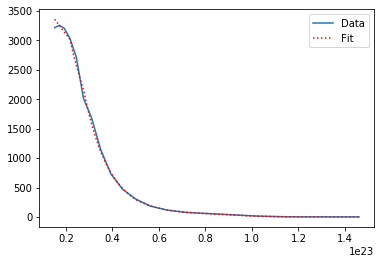

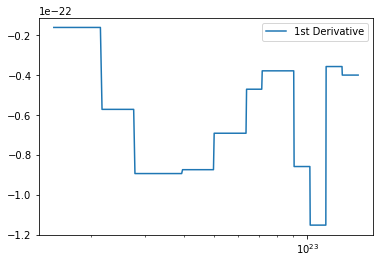

2.1755327285123432e+22


In [71]:
x_min_cloud = spline_method(x_cloud_x[3:-6], y_cloud_y[3:-6])[0]
print(x_min_cloud)

xmin: 2.17553e+22 n(>xmin): 10990 alpha: 4.11631 +/- 0.0297264   Log-Likelihood: -567286   ks: 0.0504301 p(ks): 4.95837e-25
Fitting done
Plot 1 done
Plot 2 done
Plot 3 done


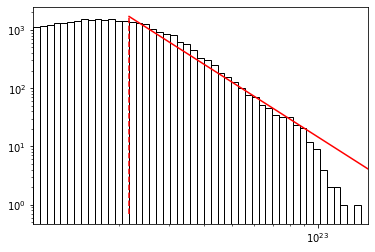

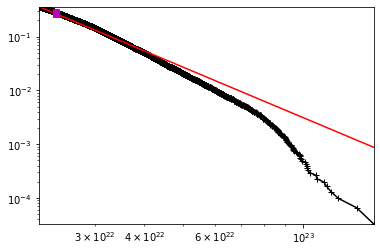

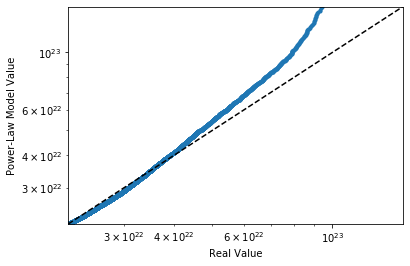

In [72]:
flat_column_density_array_cloud = find_cloud(mask_number)
myplfit_cloud = plfit_method(flat_column_density_array_cloud, x_min_cloud)

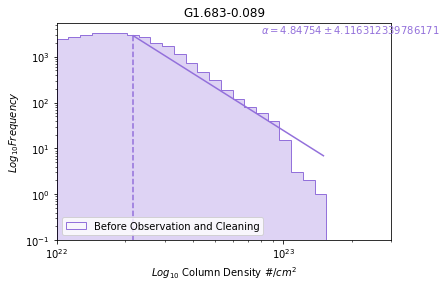

In [75]:
final_histogram(flat_column_density_array_cloud, mask_number)